In [1]:
import numpy as np
from sklearn.decomposition import PCA

import seaborn as sns; 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
from SOM import Lattice_1D, Lattice_2D
from Visualization import plot_list_distance_matrix

# 2D Lattice

### A. Generation of the inpute data

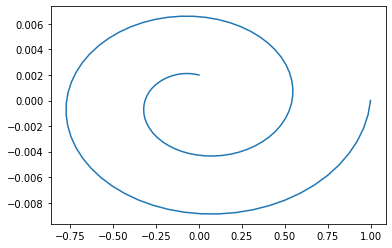

In [3]:
nb_values = 100
r = np.linspace(0.2, 1, nb_values)
theta = np.linspace(np.pi/2, 4*np.pi, nb_values)
x, y = r*np.cos(theta), r*np.sin(theta)*0.01

plt.plot(x, y)

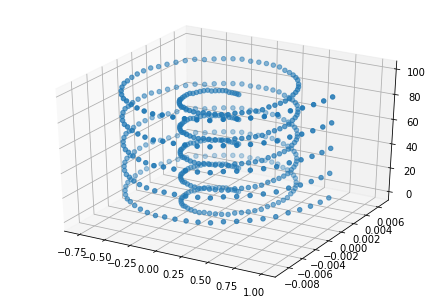

In [4]:
nb_repeat = 5
X = np.repeat([x], nb_repeat, axis=0).reshape([-1])
Y = np.repeat([y], nb_repeat, axis=0).reshape([-1])
Z = np.repeat(np.arange(0,100), nb_repeat, axis=0)
batch = np.concatenate([[X, Y, Z]], axis = 1).swapaxes(1, 0)

order = np.random.permutation(nb_values*nb_repeat)
batch = batch[order]

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(X, Y, Z)
plt.show()

### B. Model

In [5]:
input_shape=np.array([3])
lattice_dim = np.array([10, 10])
lattice = Lattice_2D(input_shape, lattice_dim)
lattice.set_update_function(node_distance = lattice.node_distance, 
                             epsilon_0 = 1, 
                             sigma_0 = 3, 
                             t_max = 500)

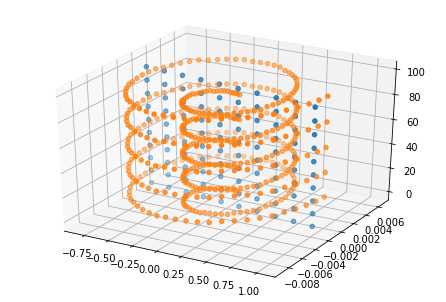

In [6]:
lattice.init_weight_pca(batch)

lattice_x = lattice.get_weight()[:, :, 0].reshape([-1])
lattice_y = lattice.get_weight()[:, :, 1].reshape([-1])
lattice_z = lattice.get_weight()[:, :, 2].reshape([-1])


fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(lattice_x, lattice_y, lattice_z)
ax.scatter(X, Y, Z)
plt.show()

In [7]:
lattice.train(batch)

lattice_x = lattice.get_weight()[:, :, 0].reshape([-1])
lattice_y = lattice.get_weight()[:, :, 1].reshape([-1])
lattice_z = lattice.get_weight()[:, :, 2].reshape([-1])


fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(lattice_x, lattice_y, lattice_z)
ax.scatter(X, Y, Z)
plt.show()

NameError: name 'node_i' is not defined

# 2D Latice, With Stimuli

### A. Preparation of the input data

In [ ]:
nb_values = 3 #3 vectors
ref_vector_1 = np.array([10, 10])
ref_vector_2 = np.array([80, 50])
ref_vector_3 = np.array([0, 99])
batch = np.concatenate([[ref_vector_1, ref_vector_2, ref_vector_3]])

nb_repeat = 10
training_batch = np.repeat(batch, nb_repeat, axis=0)

order = np.random.permutation(nb_values*nb_repeat)
training_batch = training_batch[order]

### B. Model

In [ ]:
input_shape=np.array([2])
lattice_dim = np.array([100, 100])
lattice = Lattice_2D(input_shape, lattice_dim)
lattice.set_update_function(node_distance = lattice.node_distance, 
                             epsilon_0 = 1, 
                             sigma_0 = 20, 
                             t_max = 500)

In [ ]:
plot_list_ref_vector(lattice, batch)

In [ ]:
lattice.init_weight_pca(batch)
plot_list_ref_vector(lattice, batch)

In [ ]:
lattice.train(training_batch)
plot_list_ref_vector(lattice, batch)

In [ ]:
lattice.train(training_batch)
plot_list_ref_vector(lattice, batch)

In [ ]:
lattice.train(training_batch)
plot_list_ref_vector(lattice, batch)

# 1D Lattice, 2D Input

### A. Preparation of the input data

(100, 2)

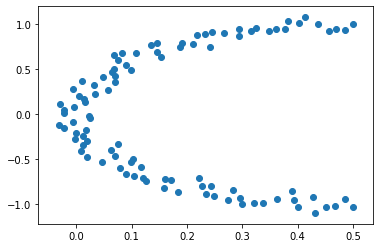

In [282]:
nb_values = 100
theta = np.linspace(np.pi/2, 3/2*np.pi, nb_values)
theta = theta[np.random.permutation(nb_values)]
r_noise = np.random.normal(1, 0.05, nb_values)
x, y = r_noise*np.cos(theta), r_noise*np.sin(theta)
x = (x+1)/2
plt.scatter(x, y)

batch = np.concatenate([[x, y]], axis = 0).swapaxes(1,0)

nb_train = 10
train_batch = np.repeat([batch], nb_train, axis = 0).reshape([-1, 2])

batch.shape

### B. Model

In [283]:
lattice_dim = np.array([100])
input_shape = [2]
lattice = Lattice_1D(input_shape = input_shape, 
                     lattice_dim = lattice_dim)


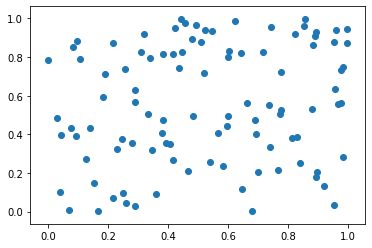

In [284]:
lattice_x = lattice.get_weight()[:, 0]
lattice_y = lattice.get_weight()[:, 1]
plt.scatter(lattice_x, lattice_y)

In [285]:
lattice.init_weight_pca(batch)

C:\Users\DELL\Anaconda3\envs\thesis\lib\site-packages\ipykernel_launcher.py:190: DeprecationWarning: object of type <class 'numpy.ndarray'> cannot be safely interpreted as an integer.


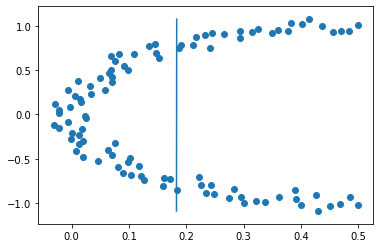

In [286]:
lattice_x = lattice.get_weight()[:, 0]
lattice_y = lattice.get_weight()[:, 1]
plt.plot(lattice_x, lattice_y)
plt.scatter(x, y)

In [287]:
# lattice.set_update_function(node_distance = lattice.node_distance, 
#                              epsilon_0 = 1, 
#                              sigma_0 = 50, 
#                              t_max = 2000)
# lattice.train(batch,batch_update=True)
# lattice_x = lattice.get_weight()[:, 0]
# lattice_y = lattice.get_weight()[:, 1]
# plt.scatter(lattice_x, lattice_y)

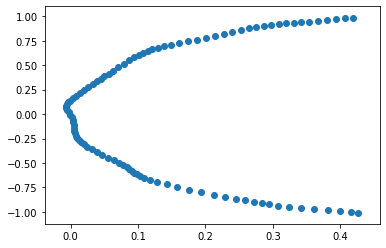

In [288]:
lattice.set_update_function(node_distance = lattice.node_distance, 
                             epsilon_0 = 0.7, 
                             sigma_0 = 10, 
                             t_max = 1000)
lattice.train(train_batch,batch_update=False)
lattice_x = lattice.get_weight()[:, 0]
lattice_y = lattice.get_weight()[:, 1]
plt.scatter(lattice_x, lattice_y)

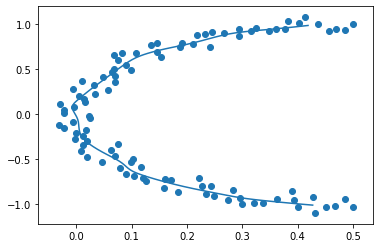

In [289]:
plt.scatter(x, y)
plt.plot(lattice_x, lattice_y)

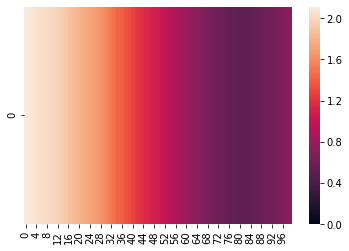

In [303]:
vector = lattice.relative_distance(np.array([-0.3, -1])).reshape([1, -1])
sns.heatmap(vector, vmin=0)

In [ ]:
vector = lattice.relative_distance(np.array([-0.3, -1])).reshape([1, -1])
sns.heatmap(vector, vmin=0)

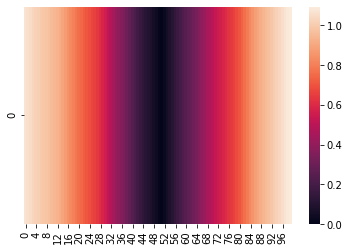

In [305]:
vector = lattice.relative_distance(np.array([0, 0])).reshape([1, -1])
sns.heatmap(vector, vmin=0)

In [308]:
node_1 = lattice.find_closest(np.array([0, 0]))
node_2 = lattice.find_closest(np.array([1, 3]))

In [310]:
node_1.weight

array([-0.00079898, -0.00758721])

In [311]:
node_1 += np.array([0, 2])

In [312]:
node_1.weight

array([-7.98984426e-04,  1.99241279e+00])

# 1D lattice, 3D Input

### A. Preparation of the input data

In [670]:
def scatter_3d(x, y, z):
    
    fig = plt.figure()
    ax = Axes3D(fig)


    ax.scatter(x, y, z)
    plt.show()

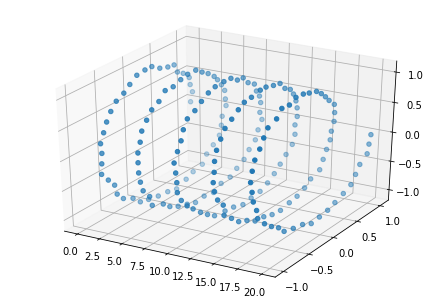

(200, 3)

In [800]:
nb_value = 200
X = np.linspace(0, 20, nb_value)
X_noise = np.random.normal(0, 0.05, nb_value)
R_noise = np.random.normal(1, 0.02, nb_value)
X += X_noise
theta = np.linspace(0, 5*2*np.pi, nb_value)
Y, Z = R_noise*np.cos(theta), R_noise*np.sin(theta)
batch = np.concatenate([[X, Y, Z]], axis=0).swapaxes(1, 0)


order = np.random.permutation(nb_value)
batch = batch[order]

nb_train = 10
train_batch = np.repeat([batch], nb_train, axis = 0).reshape([-1, 3])



scatter_3d(X, Y, Z)
batch.shape

### B. Model

In [832]:
lattice_dim = np.array([200])
input_shape = [3]
lattice = Lattice_1D(input_shape = input_shape, 
                     lattice_dim = lattice_dim)

lattice.set_update_function(node_distance = lattice.node_distance, 
                             epsilon_0 = 0.7, 
                             sigma_0 = 10, 
                             t_max = 2000)

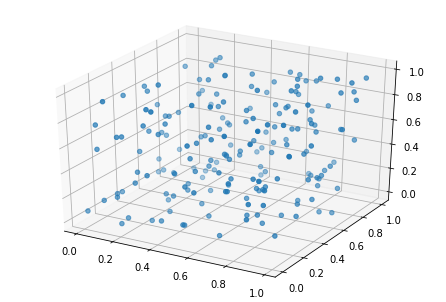

In [833]:
lattice_x = lattice.get_weight()[:, 0]
lattice_y = lattice.get_weight()[:, 1]
lattice_z = lattice.get_weight()[:, 2]
scatter_3d(lattice_x, lattice_y, lattice_z)

In [822]:
lattice.init_weight_pca(batch)

C:\Users\DELL\Anaconda3\envs\thesis\lib\site-packages\ipykernel_launcher.py:190: DeprecationWarning: object of type <class 'numpy.ndarray'> cannot be safely interpreted as an integer.


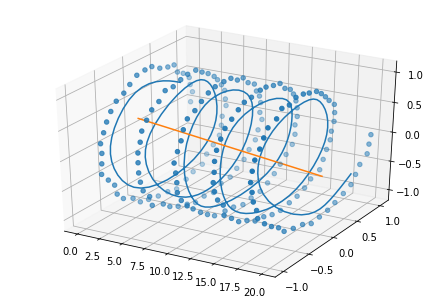

In [826]:
lattice.train(train_batch,batch_update=False)


lattice_x = lattice.get_weight()[:, 0]
lattice_y = lattice.get_weight()[:, 1]
lattice_z = lattice.get_weight()[:, 2]
# scatter_3d(lattice_x, lattice_y, lattice_z)

fig = plt.figure()
ax = Axes3D(fig)
ax.plot(lattice_x, lattice_y, lattice_z)
ax.plot(lattice_x_pca, lattice_y_pca, lattice_z_pca)
ax.scatter(X, Y, Z)
plt.show()